#  Social Media Hybrid Recommender — Friend's Version



1 — Imports & seed

In [1]:

import numpy as np, pandas as pd, random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
random.seed(123); np.random.seed(123)


2 — Generate fake posts, users, ratings

In [2]:

def make_fake_social(n_users=300, n_items=800):
    platforms = ['YouTube','Instagram','X','Snapchat','Facebook']
    topics = ['tech','travel','food','sports','fashion','music','education']
    items = []
    for i in range(n_items):
        p = random.choice(platforms)
        t = random.choice(topics)
        txt = f"{p} {t} post {i} #{t} #{p.lower()}"
        items.append({'id': i, 'platform': p, 'topic': t, 'title': f"{p} {t} post {i}", 'content': txt})
    items_df = pd.DataFrame(items)

    interactions = []
    for u in range(n_users):
        k = random.randint(30,80)
        sampled = np.random.choice(n_items, k, replace=False)
        fav = random.choice(topics)
        for it in sampled:
            val = 3.0 + np.random.randn()*0.6
            if items_df.loc[it,'topic'] == fav:
                val += abs(np.random.randn()) * 1.0
            rating = float(min(5.0, max(1.0, round(val,1))))
            interactions.append({'user': u, 'item': it, 'score': rating})
    interactions_df = pd.DataFrame(interactions)
    return items_df, interactions_df

items_df, interactions_df = make_fake_social()
print(items_df.shape, interactions_df.shape)


(800, 5) (16673, 3)


3 — Create sparse interaction matrix

In [3]:

def build_matrix(inter_df, n_users=None, n_items=None):
    if n_users is None:
        n_users = inter_df['user'].max() + 1
    if n_items is None:
        n_items = inter_df['item'].max() + 1
    mat = csr_matrix((inter_df['score'].values, (inter_df['user'].values, inter_df['item'].values)),
                     shape=(n_users, n_items))
    return mat

M = build_matrix(interactions_df)
print("Interaction matrix:", M.shape)


Interaction matrix: (300, 800)


4 — Train a low-rank SVD model for CF

In [4]:

def fit_svd(M_csr, k=40):
    dense = M_csr.toarray()
    # user mean centering
    means = np.where(dense.sum(axis=1)!=0, dense.sum(axis=1)/(dense!=0).sum(axis=1), 0)
    centered = dense - means.reshape(-1,1)
    svd = TruncatedSVD(n_components=k, random_state=123)
    U = svd.fit_transform(centered)
    V = svd.components_.T
    return U, V, means

U_fac, V_fac, u_means = fit_svd(M, k=40)


5 — Content vectors (TF-IDF + metadata)

In [6]:

def item_content_vectors(items_df, tfidf_features=1500):
    tf = TfidfVectorizer(max_features=tfidf_features, stop_words='english')
    txt_mat = tf.fit_transform(items_df['content'].fillna(''))

    # handle sklearn version differences
    try:
        enc = OneHotEncoder(sparse_output=False)  # ✅ for new versions
    except TypeError:
        enc = OneHotEncoder(sparse=False)         # fallback for older versions

    meta_mat = enc.fit_transform(items_df[['platform','topic']])
    combined = hstack([txt_mat, csr_matrix(meta_mat)])
    combined = normalize(combined, axis=1)
    return combined, tf, enc

item_vecs, tf_model, enc_model = item_content_vectors(items_df)
print("Item vectors:", item_vecs.shape)


Item vectors: (800, 814)


6 — Helper: build user content vector

In [7]:

def build_profile(user_id, inter_df, item_vecs, min_rating=4.0):
    liked = inter_df[(inter_df['user']==user_id) & (inter_df['score']>=min_rating)]['item'].values
    if len(liked)==0:
        return np.array(item_vecs.mean(axis=0)).ravel()
    else:
        return np.array(item_vecs[liked].mean(axis=0)).ravel()


7 — Hybrid scoring & recommendation (alpha default 0.55)

In [8]:

def recommend_for_user(uid, top_n=10, alpha=0.55):
    # CF raw predictions
    cf_raw = U_fac[uid].dot(V_fac.T) + u_means[uid]
    # CBF similarity against user profile
    profile = build_profile(uid, interactions_df, item_vecs)
    cbf_raw = cosine_similarity(profile.reshape(1,-1), item_vecs).ravel()
    # normalize
    cf_n = (cf_raw - cf_raw.min()) / (cf_raw.max() - cf_raw.min() + 1e-9)
    cbf_n = (cbf_raw - cbf_raw.min()) / (cbf_raw.max() - cbf_raw.min() + 1e-9)
    hybrid_score = alpha * cf_n + (1-alpha) * cbf_n
    seen = set(interactions_df[interactions_df['user']==uid]['item'].tolist())
    candidates = [(i, hybrid_score[i]) for i in range(len(hybrid_score)) if i not in seen]
    top = sorted(candidates, key=lambda x: x[1], reverse=True)[:top_n]
    recs = pd.DataFrame([{'item':i, 'rank_score':s} for i,s in top])
    recs = recs.merge(items_df, left_on='item', right_on='id', how='left')
    return recs

# Example
print(recommend_for_user(7, top_n=8))


   item  rank_score   id   platform    topic                       title  \
0   285    0.811553  285  Instagram  fashion  Instagram fashion post 285   
1    45    0.777549   45  Instagram  fashion   Instagram fashion post 45   
2   292    0.723355  292  Instagram    music    Instagram music post 292   
3   633    0.710576  633  Instagram    music    Instagram music post 633   
4    36    0.695844   36  Instagram    music     Instagram music post 36   
5   648    0.684381  648  Instagram    music    Instagram music post 648   
6    80    0.679075   80  Instagram    music     Instagram music post 80   
7   766    0.662199  766  Instagram    music    Instagram music post 766   

                                          content  
0  Instagram fashion post 285 #fashion #instagram  
1   Instagram fashion post 45 #fashion #instagram  
2      Instagram music post 292 #music #instagram  
3      Instagram music post 633 #music #instagram  
4       Instagram music post 36 #music #instagram  
5  

8 — Quick plots to illustrate results

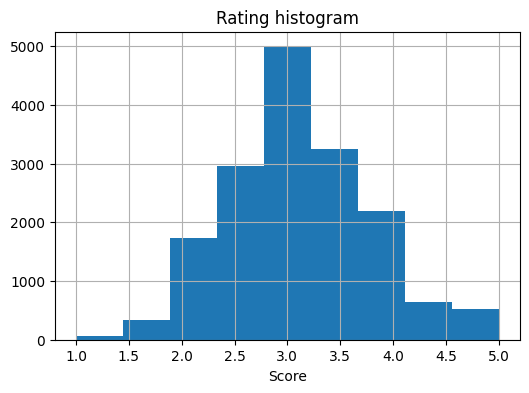

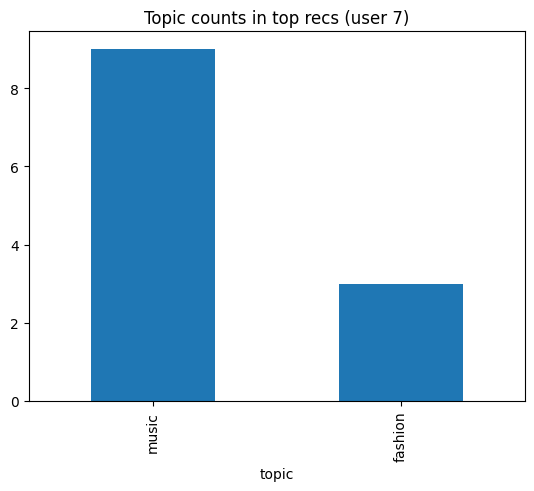

In [9]:

def show_rating_hist(inter_df):
    plt.figure(figsize=(6,4))
    inter_df['score'].hist(bins=9)
    plt.title("Rating histogram"); plt.xlabel("Score"); plt.show()

show_rating_hist(interactions_df)

# show distribution of topics among top recs for a user
r = recommend_for_user(7, top_n=12)
r['topic'].value_counts().plot(kind='bar', title='Topic counts in top recs (user 7)')
plt.show()
